# Feature Engineering for QuickBooks Sales Forecasting

## Introduction
This notebook focuses on transforming raw sales data into model-ready features for our sales forecasting model. Feature engineering is a critical step in the machine learning pipeline that can significantly impact model performance. 

In this notebook, we will:
1. Load and explore the raw sales data
2. Create daily and category-level aggregations
3. Generate time series features (lags and rolling statistics)
4. Add calendar-based features
5. Prepare the final feature set for model training

The engineered features will capture historical patterns, seasonality, and trends in the sales data, enabling our forecasting models to make more accurate predictions.


## Setup and Data Preparation

In this section, we'll import the necessary libraries for data manipulation, analysis, and visualization. We'll also set up the visualization style for consistent and professional-looking plots throughout the notebook.


In [51]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta

# Set visualization style
plt.style.use('ggplot')
sns.set_theme(style="whitegrid")
%matplotlib inline

## Data Loading and Initial Exploration

We'll start by loading the raw sales data from a CSV file. This dataset contains transaction-level information including dates, product categories, revenue, and units sold. Understanding this raw data is essential before we begin the feature engineering process.


In [52]:
# Load the sales data
sales_df = pd.read_csv('../data/raw/sales.csv')

# Convert date to datetime
sales_df['date'] = pd.to_datetime(sales_df['date'])

# Display the first few rows
sales_df.head()

,date,category,product,units_sold,revenue,product_price,promo_flag,is_holiday_season,category_popularity_30d
0,2020-05-08,Electronics,Smart Speaker,7,991.63,141.66,0,0,1.03
1,2020-05-08,Groceries,Organic Cereal,307,1556.42,5.07,0,0,1.10
2,2020-05-08,Clothing,Running Shoes,54,3145.90,58.26,0,0,0.95
3,2020-05-08,Books,Business Book,86,1869.15,21.73,0,0,1.10
4,2020-05-08,Furniture,Office Chair,7,822.02,117.43,0,0,0.93


## Data Aggregation and Feature Creation

For our forecasting model, we need to transform the transaction-level data into time series data at the appropriate granularity. We'll aggregate the data to the category-daily level, which will allow us to forecast sales by product category on a daily basis.


In [53]:
# Aggregate data to category-daily level
print("Aggregating data to category-daily level...")
category_daily = sales_df.groupby(['date', 'category']).agg(
    revenue=('revenue', 'sum'),
    units_sold=('units_sold', 'sum')
).reset_index()

# Display the aggregated data
category_daily.head()

Aggregating data to category-daily level...


,date,category,revenue,units_sold
0,2020-05-08,Beauty,3123.75,158
1,2020-05-08,Books,1869.15,86
2,2020-05-08,Clothing,3145.90,54
3,2020-05-08,Electronics,991.63,7
4,2020-05-08,Furniture,822.02,7


### Daily Metrics Creation

First, we'll create daily aggregations for overall sales metrics. This gives us a high-level view of total sales performance each day.


In [55]:
# Create a daily aggregation for overall metrics
print("Creating daily metrics...")
daily_metrics = sales_df.groupby('date').agg(total_sales=('revenue', 'sum')).reset_index()
daily_metrics.head()

Creating daily metrics...


,date,total_sales
0,2020-05-08,14660.31
1,2020-05-09,16599.84
2,2020-05-10,18156.94
3,2020-05-11,18851.50
4,2020-05-12,18416.72


### Pivoting Category Data

To create features for each product category, we need to transform the data from a long format to a wide format. This will give us one column per category, making it easier to create category-specific features later.


In [56]:
# Pivot categories to columns for revenue
print("Pivoting category revenue data...")
revenue_pivot = category_daily.pivot(index='date', columns='category', values='revenue').reset_index()
revenue_pivot = revenue_pivot.fillna(0)  # Fill NaN with 0

# Merge daily metrics with revenue pivot
features_df = pd.merge(daily_metrics, revenue_pivot, on='date', how='left')
features_df.head()

Pivoting category revenue data...


,date,total_sales,Beauty,Books,Clothing,Electronics,Furniture,Groceries,Sports,Toys
0,2020-05-08,14660.31,3123.75,1869.15,3145.90,991.63,822.02,1556.42,1793.46,1357.98
1,2020-05-09,16599.84,3522.52,2413.48,3634.32,840.23,883.30,1620.57,1569.33,2116.09
2,2020-05-10,18156.94,3195.38,2424.01,4321.36,882.06,1215.43,1653.73,2609.50,1855.47
3,2020-05-11,18851.50,3494.76,2288.23,4054.60,1498.61,1499.52,1874.54,1931.15,2210.09
4,2020-05-12,18416.72,3110.31,2322.06,4121.08,2432.77,1013.20,1652.64,1989.02,1775.64


### Adding Units Sold Features

In addition to revenue, we'll also include units sold as features. This provides another dimension of sales performance that can be valuable for forecasting.


In [57]:
# Pivot categories to columns for units sold
print("Pivoting category units sold data...")
units_pivot = category_daily.pivot(index='date', columns='category', values='units_sold').reset_index()
units_pivot = units_pivot.fillna(0)

# Rename unit columns to match naming convention (e.g., Beauty_units)
units_pivot.columns = [f"{col}_units" if col != 'date' else col for col in units_pivot.columns]

# Merge units sold pivot into the features_df
features_df = pd.merge(features_df, units_pivot, on='date', how='left')

# Display the feature dataframe
features_df.head()

Pivoting category units sold data...


,date,total_sales,Beauty,Books,Clothing,Electronics,Furniture,Groceries,Sports,Toys,Beauty_units,Books_units,Clothing_units,Electronics_units,Furniture_units,Groceries_units,Sports_units,Toys_units
0,2020-05-08,14660.31,3123.75,1869.15,3145.90,991.63,822.02,1556.42,1793.46,1357.98,158,86,54,7,7,307,42,40
1,2020-05-09,16599.84,3522.52,2413.48,3634.32,840.23,883.30,1620.57,1569.33,2116.09,173,95,62,6,7,326,35,64
2,2020-05-10,18156.94,3195.38,2424.01,4321.36,882.06,1215.43,1653.73,2609.50,1855.47,146,98,74,6,10,356,59,53
3,2020-05-11,18851.50,3494.76,2288.23,4054.60,1498.61,1499.52,1874.54,1931.15,2210.09,161,90,66,10,13,373,44,59
4,2020-05-12,18416.72,3110.31,2322.06,4121.08,2432.77,1013.20,1652.64,1989.02,1775.64,147,101,66,17,9,344,47,50


## Time Series Feature Engineering

Time series forecasting relies heavily on historical patterns. We'll create two types of time series features:

1. **Lag Features**: Values from previous time periods (e.g., sales from 1 day ago, 7 days ago)
2. **Rolling Window Features**: Statistical aggregations over past periods (e.g., 7-day average sales)

These features help the model capture trends, seasonality, and autocorrelation in the data. For example, lag features can capture weekly patterns, while rolling averages smooth out noise and highlight longer-term trends.


In [59]:
# Sort by date to ensure correct calculation
print("Creating lag and rolling features per category...")
features_df = features_df.sort_values('date')

# Get all category columns (excluding units columns and date/metrics)
category_cols = [col for col in revenue_pivot.columns if col != 'date']
category_unit_cols = [f"{cat}_units" for cat in category_cols] # e.g., Beauty_units, Electronics_units

# Define lag days and rolling windows
LAG_DAYS = [1, 7, 14, 28]
ROLLING_WINDOWS = [7, 14, 28]

Creating lag and rolling features per category...


### Creating Lag Features

Lag features represent the value of a variable at previous time points. For example, a 7-day lag feature contains the value from exactly 7 days ago. These features are crucial for time series forecasting as they directly encode the autocorrelation structure of the data.


In [60]:
# Initialize dictionaries to store new features before adding them all at once
lag_features = {}
rolling_avg_features = {}
rolling_std_features = {}

# Create lag features
for lag in LAG_DAYS:
    # Revenue lags
    for category in category_cols:
        col_name = f'{category}_lag_{lag}d'
        lag_features[col_name] = features_df[category].shift(lag)

    for category in category_unit_cols:
        # Units sold lags
        lag_features[f'{category}_lag_{lag}d'] = features_df[category].shift(lag)

### Creating Rolling Window Features

Rolling window features capture trends and smooth out noise in the time series data. We'll create two types:

1. **Rolling Averages**: The mean value over a specific window of past days
2. **Rolling Standard Deviations**: The volatility or variability over a specific window

These features help the model understand both the trend (through averages) and the stability/volatility (through standard deviations) of sales patterns.


In [61]:
# Create rolling average features
for window in ROLLING_WINDOWS:
    # Revenue rolling averages
    for category in category_cols:
        col_name = f'{category}_rolling_avg_{window}d'
        rolling_avg_features[col_name] = features_df[category].shift(1).rolling(window, min_periods=1).mean()

    for category in category_unit_cols:
        rolling_avg_features[f'{category}_rolling_avg_{window}d'] = (
            features_df[category].shift(1).rolling(window, min_periods=1).mean()
        )

# Create rolling volatility features (standard deviation)
for window in ROLLING_WINDOWS:
    # Revenue volatility
    for category in category_cols:
        col_name = f'{category}_rolling_std_{window}d'
        rolling_std_features[col_name] = features_df[category].shift(1).rolling(window, min_periods=1).std()

    for category in category_unit_cols:
        rolling_std_features[f'{category}_rolling_std_{window}d'] = (
            features_df[category].shift(1).rolling(window, min_periods=1).std()
        )

### Combining All Features

Now that we've created our lag and rolling window features, we'll combine them with our original features to create a comprehensive feature set. This step is important for ensuring all features are properly aligned by date before we proceed with adding time-based features.


In [62]:
# Create DataFrames from our dictionaries
lag_df = pd.DataFrame(lag_features, index=features_df.index)
rolling_avg_df = pd.DataFrame(rolling_avg_features, index=features_df.index)
rolling_std_df = pd.DataFrame(rolling_std_features, index=features_df.index)

# Combine all at once using concat
features_df = pd.concat([
    features_df,
    lag_df,
    rolling_avg_df,
    rolling_std_df
], axis=1)

# Display the first few rows to see the new features
print(f"Feature dataframe shape after adding rolling features: {features_df.shape}")
features_df.head()

Feature dataframe shape after adding rolling features: (1826, 178)


,date,total_sales,Beauty,Books,Clothing,Electronics,Furniture,Groceries,Sports,Toys,...,Sports_rolling_std_28d,Toys_rolling_std_28d,Beauty_units_rolling_std_28d,Books_units_rolling_std_28d,Clothing_units_rolling_std_28d,Electronics_units_rolling_std_28d,Furniture_units_rolling_std_28d,Groceries_units_rolling_std_28d,Sports_units_rolling_std_28d,Toys_units_rolling_std_28d
0,2020-05-08,14660.31,3123.75,1869.15,3145.90,991.63,822.02,1556.42,1793.46,1357.98,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2020-05-09,16599.84,3522.52,2413.48,3634.32,840.23,883.30,1620.57,1569.33,2116.09,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2020-05-10,18156.94,3195.38,2424.01,4321.36,882.06,1215.43,1653.73,2609.50,1855.47,...,158.483843,536.064722,10.606602,6.363961,5.656854,0.707107,0.000000,13.435029,4.949747,16.970563
3,2020-05-11,18851.50,3494.76,2288.23,4054.60,1498.61,1499.52,1874.54,1931.15,2210.09,...,547.434801,385.173090,13.527749,6.244998,10.066446,0.577350,1.732051,24.704925,12.342339,12.013881
4,2020-05-12,18416.72,3110.31,2322.06,4121.08,2432.77,1013.20,1652.64,1989.02,1775.64,...,447.971366,381.972147,11.090537,5.315073,8.326664,1.892969,2.872281,29.602928,10.099505,10.360180


## Calendar-Based Feature Creation

Calendar-based features are essential for capturing seasonality and cyclical patterns in sales data. These features help the model understand:

- **Yearly seasonality**: Patterns that repeat annually (e.g., holiday shopping seasons)
- **Monthly patterns**: End-of-month or beginning-of-month effects
- **Weekly cycles**: Weekend vs. weekday differences
- **Special periods**: Like November for Black Friday sales

By extracting these components from the date, we enable the model to learn seasonal patterns without requiring years of historical data.


In [63]:
# Extract date components for the feature dataframe
print("Adding time features to the final dataframe...")

# Create a dictionary to store time features
time_features = {
    'year': features_df['date'].dt.year,
    'month': features_df['date'].dt.month,
    'day_of_week': features_df['date'].dt.dayofweek,
    'week_of_year': features_df['date'].dt.isocalendar().week,
    'quarter': features_df['date'].dt.quarter
}

# Boolean features
time_features['is_weekend'] = features_df['date'].dt.dayofweek.isin([5, 6]).astype(int)
time_features['is_month_end'] = features_df['date'].dt.is_month_end.astype(int)
time_features['is_month_start'] = features_df['date'].dt.is_month_start.astype(int)
time_features['is_november'] = (features_df['date'].dt.month == 11).astype(int)  # Black Friday month indicator


Adding time features to the final dataframe...


### Adding Time Features to the Dataset

Now we'll convert our time features dictionary into a DataFrame and add these features to our main feature set. This completes our feature engineering for calendar-based patterns.


In [64]:
# Create DataFrame from time features and concatenate with main DataFrame
time_df = pd.DataFrame(time_features, index=features_df.index)
features_df = pd.concat([features_df, time_df], axis=1)

# Display the enhanced dataframe
features_df.head()

,date,total_sales,Beauty,Books,Clothing,Electronics,Furniture,Groceries,Sports,Toys,...,Toys_units_rolling_std_28d,year,month,day_of_week,week_of_year,quarter,is_weekend,is_month_end,is_month_start,is_november
0,2020-05-08,14660.31,3123.75,1869.15,3145.90,991.63,822.02,1556.42,1793.46,1357.98,...,NaN,2020,5,4,19,2,0,0,0,0
1,2020-05-09,16599.84,3522.52,2413.48,3634.32,840.23,883.30,1620.57,1569.33,2116.09,...,NaN,2020,5,5,19,2,1,0,0,0
2,2020-05-10,18156.94,3195.38,2424.01,4321.36,882.06,1215.43,1653.73,2609.50,1855.47,...,16.970563,2020,5,6,19,2,1,0,0,0
3,2020-05-11,18851.50,3494.76,2288.23,4054.60,1498.61,1499.52,1874.54,1931.15,2210.09,...,12.013881,2020,5,0,20,2,0,0,0,0
4,2020-05-12,18416.72,3110.31,2322.06,4121.08,2432.77,1013.20,1652.64,1989.02,1775.64,...,10.360180,2020,5,1,20,2,0,0,0,0


## Final Data Preparation

Before saving our engineered features, we need to perform some final cleaning and preparation steps:

1. **Handle Missing Values**: Remove rows with NaN values that result from lag/rolling calculations
2. **Verify Feature Creation**: Ensure all expected features are present
3. **Remove Redundant Features**: Drop columns that are no longer needed
4. **Set Date Index**: Convert the date column to a datetime index for time series analysis

These steps ensure our feature set is clean, complete, and properly formatted for model training.


In [66]:
# Drop rows with NaN values (from lag/rolling features at the beginning of the series)
print("Preparing final feature set...")
features_df_clean = features_df.dropna().copy()

# Verify rolling features are included
rolling_cols = [col for col in features_df_clean.columns if 'rolling' in col]
print(f"Number of rolling feature columns: {len(rolling_cols)}")
if len(rolling_cols) > 0:
    print(f"Example rolling features: {rolling_cols[:5]}")
else:
    print("WARNING: No rolling features found in final dataset!")

# Drop the 'total_sales' column, we don't need it. We have category level revenue
features_df_clean.drop('total_sales', axis=1, inplace=True)

# Set date as index
features_df_clean['date'] = pd.to_datetime(features_df_clean['date'])
features_df_clean.set_index('date', inplace=True)

Preparing final feature set...
Number of rolling feature columns: 96
Example rolling features: ['Beauty_rolling_avg_7d', 'Books_rolling_avg_7d', 'Clothing_rolling_avg_7d', 'Electronics_rolling_avg_7d', 'Furniture_rolling_avg_7d']


### Saving Engineered Features

Now that our feature engineering is complete, we'll save the processed dataset to a CSV file for use in model training. This ensures we don't need to repeat the feature engineering process each time we want to train or evaluate a model.


In [67]:
# Save the engineered features
features_df_clean.to_csv('../data/processed/sales_engineered_features.csv', index=True)
print(f"Saved engineered features with shape: {features_df_clean.shape} to '../data/processed/sales_engineered_features.csv'")

Saved engineered features with shape: (1798, 185) to '../data/processed/sales_engineered_features.csv'


### Feature Categorization

For documentation and better understanding of our feature set, we'll categorize the features by type. This helps us track what kinds of features we've created and how many of each type are included in the final dataset.


In [68]:
# Show feature counts by type for documentation
feature_types = {
    'Date features': [col for col in features_df_clean.columns if col in ['year', 'month', 'day_of_week', 'is_weekend', 'week_of_year', 'quarter', 'is_month_end', 'is_month_start', 'is_november']],
    'Daily metrics': [col for col in features_df_clean.columns if col in ['total_sales', 'total_units', 'transaction_count', 'unique_categories']],
    'Category revenues': [col for col in features_df_clean.columns if col in category_cols],
    'Lag features': [col for col in features_df_clean.columns if 'lag' in col],
    'Rolling average features': [col for col in features_df_clean.columns if 'rolling_avg' in col],
    'Rolling std features': [col for col in features_df_clean.columns if 'rolling_std' in col]
}

for feature_type, cols in feature_types.items():
    print(f"{feature_type}: {len(cols)} features")

Date features: 9 features
Daily metrics: 0 features
Category revenues: 8 features
Lag features: 64 features
Rolling average features: 48 features
Rolling std features: 48 features


## Summary and Visualization

In this final section, we'll summarize the feature engineering process and visualize some of the key features we've created. This helps us:

1. Document what we've accomplished
2. Understand the scale and scope of our feature set
3. Verify that our engineered features capture the patterns we expect

Visualizing the features is particularly important as it allows us to see how lag features and rolling statistics relate to the original time series data.


In [69]:
# Summary of feature engineering process
print("Feature Engineering Summary:")
print(f"- Raw data shape: {sales_df.shape}")
print(f"- Engineered features shape: {features_df_clean.shape}")
print(f"- Total features created: {features_df_clean.shape[1]}")
print(f"- Date range: {features_df_clean.index.min()} to {features_df_clean.index.max()}")
print(f"- Categories included: {', '.join(category_cols)}")
print(f"- Rolling windows used: {', '.join([str(w) for w in ROLLING_WINDOWS])}")
print(f"- Lag periods used: {', '.join([str(l) for l in LAG_DAYS])}")

Feature Engineering Summary:
- Raw data shape: (14608, 9)
- Engineered features shape: (1798, 185)
- Total features created: 185
- Date range: 2020-06-05 00:00:00 to 2025-05-07 00:00:00
- Categories included: Beauty, Books, Clothing, Electronics, Furniture, Groceries, Sports, Toys
- Rolling windows used: 7, 14, 28
- Lag periods used: 1, 7, 14, 28


### Feature Visualization

To better understand our engineered features, we'll visualize them for a sample category. This visualization includes:

1. **Original Revenue**: The raw revenue time series for the category
2. **Rolling Averages**: How different rolling window sizes smooth the data
3. **Lag Features**: How the time series looks when shifted by different lag periods

These visualizations help us verify that our features are correctly capturing the temporal patterns in the data and provide insights into which features might be most useful for forecasting.


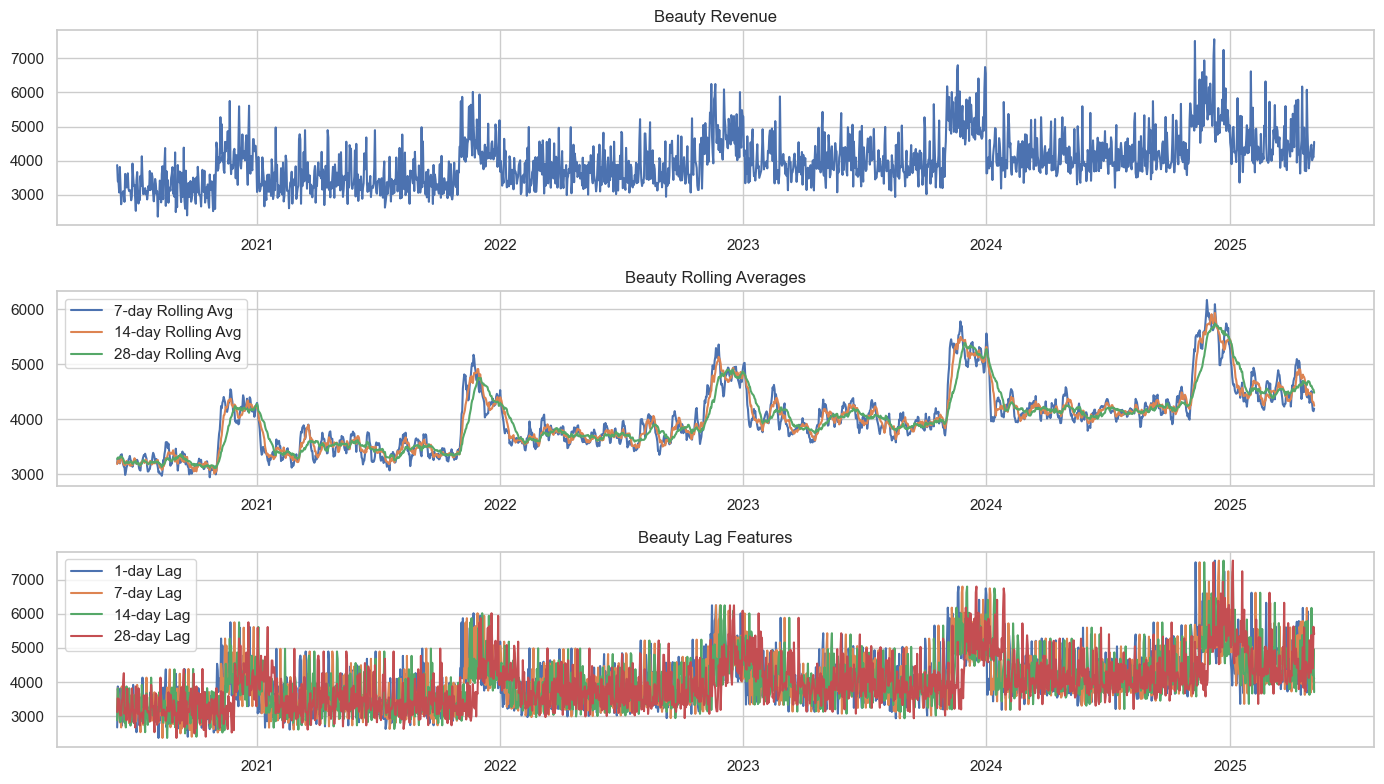

In [70]:
# Visualize a sample of the features for one category
sample_category = category_cols[0]
plt.figure(figsize=(14, 8))

# Plot original revenue
plt.subplot(3, 1, 1)
plt.plot(features_df_clean.index, features_df_clean[sample_category])
plt.title(f'{sample_category} Revenue')
plt.grid(True)

# Plot rolling averages
plt.subplot(3, 1, 2)
for window in ROLLING_WINDOWS:
    plt.plot(features_df_clean.index, features_df_clean[f'{sample_category}_rolling_avg_{window}d'],
             label=f'{window}-day Rolling Avg')
plt.title(f'{sample_category} Rolling Averages')
plt.legend()
plt.grid(True)

# Plot lag features
plt.subplot(3, 1, 3)
for lag in LAG_DAYS:
    plt.plot(features_df_clean.index, features_df_clean[f'{sample_category}_lag_{lag}d'],
             label=f'{lag}-day Lag')
plt.title(f'{sample_category} Lag Features')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


## Conclusion

In this notebook, we've successfully transformed raw sales data into a rich set of features for time series forecasting. We've:

1. **Aggregated** transaction-level data to the appropriate daily-category level
2. **Created time series features** including lags and rolling statistics to capture temporal patterns
3. **Added calendar-based features** to capture seasonality and cyclical patterns
4. **Cleaned and prepared** the final feature set for model training

The resulting feature set includes a comprehensive collection of predictors that capture various aspects of the sales patterns, including:
- Historical sales values at different lag periods
- Smoothed trends through rolling averages
- Volatility indicators through rolling standard deviations
- Seasonal and cyclical patterns through calendar features

These engineered features will be used in the next notebook for model training, where we'll build and evaluate forecasting models to predict future sales by category.
